
# Preface
The following notebook is the exploration of Q_learning through a GridWorld simulation. I created this to empirically analyze results from https://sites.ualberta.ca/~szepesva/papers/nc-97-gmdp.ps.pdf by Csaba Szepesvari and Michael L. Littman, particularly results from sections 1.1 to 3.1.

In [31]:
# Imports and initialize
%config InlineBackend.figure_format='retina'
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
plt.rcParams['figure.figsize'] = (12, 12)

# Creating the environment
The environment here is modeled as a grid world with the following parameters:


*   8*10 states
*   Pr(y|x,a) = 1, i.e. The actions have deterministic outcomes
*   Cost function is, c(y) = 100 if y is an obstacle or edge, c(y) = 1 if y is another cell, c(y) = -100 if y is the goals state.


In [32]:
class GridWorld:
    def __init__(self):
        self.shape = (8, 10)
        self.states = [(i,j) for i in range(self.shape[0]) for j in range(self.shape[1])]
        self.obstacles = [(4, 4), (5, 4), (6, 4), (7, 4), 
                          (2,7), (3,7), (2,8), (2,9), (0,2),
                          (1,2)
                         ] # obstacle coordinates
        self.goal = (7, 9)
        self.start_state = (0,0)
        self.state = self.start_state
    
    def reset(self):
        self.state = self.start_state
        
    def visualize(self):
      # Draw gridlines
      x = [i for i in range(self.shape[0] + 1)]
      y = [i for i in range(self.shape[1] + 1)]
      plt.grid(visible=True, which="major", axis='both')
      plt.xticks(x)
      plt.yticks(y)
      # Mark the goal and start nodes
      plt.text(self.start_state[0] + 0.3, self.start_state[1] + 0.3, "A", fontsize=20, fontweight=2)
      plt.text(self.goal[0] + 0.3, self.goal[1] + 0.3, "G", fontsize=20, fontweight=2)
      ax = plt.gca()
      # Draw 0bstacles
      for o in self.obstacles:
        ax.add_patch(Rectangle((o[0], o[1]),1,1, facecolor='black',fill=True))
      plt.show()
    
    def step(self, action):
        x, y = self.state
        cost = 1
        if action == 0: # up
            next_state = (x, min(y+1, self.shape[1]-1))
            if y+1 > self.shape[1]-1: # cost of hitting the edge
              cost = 100 
        elif action == 1: # down
            next_state = (x, max(y-1, 0))
            if y-1 < 0: # cost of hitting the edge
              cost = 100 
        elif action == 2: # left
            next_state = (max(x-1,0), y)
            if x-1 < 0: # cost of hitting the edge
              cost = 100 
        elif action == 3: # right
            next_state = (min(x+1, self.shape[0]-1), y)
            if x + 1 > self.shape[0]-1: # cost of hitting the edge
              cost = 100
        if next_state in self.obstacles:
            next_state = self.state
            cost = 100
        elif next_state == self.goal:
            cost = -100
          
        self.state = next_state
        done = (next_state == self.goal)
        return next_state, done, cost

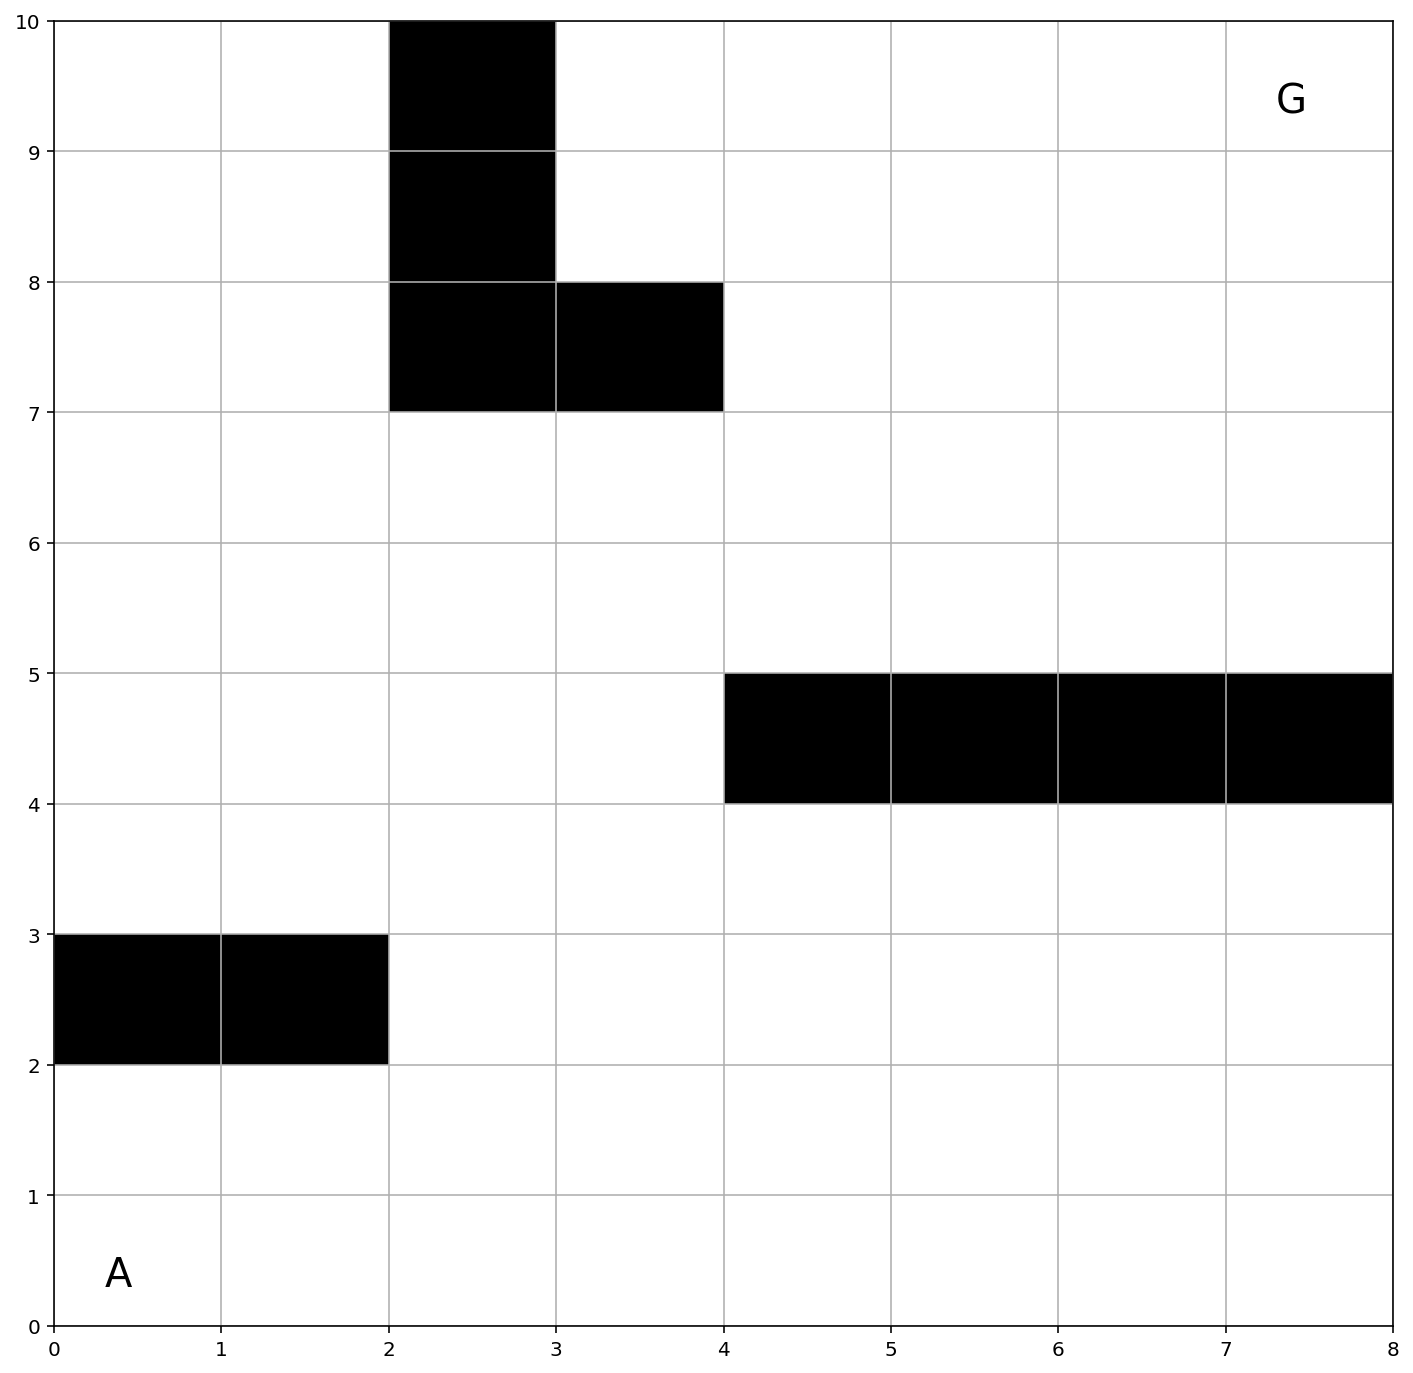

In [33]:
# Show The Environment
gridWorld = GridWorld()
gridWorld.visualize()

# Modelling The Agent
The agent is configured to use a discount factor 0.9. Which entails a slower discount rate. (gamma = 0.9)

The learning rate α = 1/N(x,a) which in laymann terms is the number of times a particular actions is taken at a given state x.
This learning rate satisfies Theorem 6 of [A Unified Analysis of Value-Function-Based
Reinforcement-Learning Algorithms](https://sites.ualberta.ca/~szepesva/papers/nc-97-gmdp.ps.pdf). Since Σ(1/n) goes to infinity as n approaches infinity and Σ(1/n^2) converges to Π^2/6 ([Basel Problem](https://en.wikipedia.org/wiki/Basel_problem)). Lastly, we are only updating the q_value for an observed state at a given time step, which sould satisfy 𝜶(x, a) = 0 if (x, a) != (xₜ, aₜ)

### Exploration/Exploitation Approach
In this agent I implemented an action selection model based on the epsilon-greedy algorithm. However the exploration rate will decay as a state is visited more often (ϵ = 1/N(x), where N(x) is the number of times a state is visited).
The rationale here beeing we want utilize our learned experience more often and eventually explore less often. There are perhaps better ways to decay the exploration rate (ideas for later).

### Evaluating Convergence
Here performance is evaluated on how fast the agent can reach the goal state (steps/episode). This entails that the agent is exploiting the fact that Q(s,a) is converging to Q*(s,a) thus allowing it to take the shortest path from start to finish. In our example environment, the agent can reach the goal state with 16 steps at best. We can empirically verify our agent is learning from the environment by seeing the number of steps eventually reduce to their optimal value. 

In [34]:
class QLearning_Agent:
  def __init__(self, env, episodes=5000, gamma=0.9):
    self.env = env
    self.qTable = np.zeros((env.shape[0] * env.shape[1], 4), dtype=np.float64)
    self.n_visits = np.zeros((env.shape[0] * env.shape[1], 4))
    self.episodes = episodes
    self.steps_per_episode = np.zeros(episodes)
    self.gamma = gamma
  
  # gets current exploration rate
  def epsilon(self, state_index):
    if np.sum(self.n_visits[state_index]) == 0:
              return 1
    return 1/np.sum(self.n_visits[state_index])
  
  
  def select_action(self, state_index):
    if np.random.uniform(low=0, high=1, size=None) < self.epsilon(state_index):
      return np.random.randint(low=0,high=4,size=None,dtype=int)
    else:
      return np.argmin(self.qTable[state_index])

  def alpha(self, state, action):
    if self.n_visits[state[0] * self.env.shape[1]+state[1]][action] == 0:
      return 1
    else:
      return 1/self.n_visits[state[0] * self.env.shape[1]+state[1]][action]
    
  def visualize_result(self):
      x = [i for i in range(self.env.shape[0] + 1)]
      y = [i for i in range(self.env.shape[1] + 1)]
      plt.grid(visible=True, which="major", axis='both')
      plt.xticks(x)
      plt.yticks(y)
      ax = plt.gca()
      scale_arrow = 0.3
      plt.text(self.env.start_state[0] + 0.3, self.env.start_state[1] + 0.3, "A", fontsize=20, fontweight=2)
      plt.text(self.env.goal[0] + 0.3, self.env.goal[1] + 0.3, "G", fontsize=20, fontweight=2)
      for o in self.env.obstacles:
        ax.add_patch(Rectangle((o[0], o[1]),1,1, facecolor='black',fill=True))
      ax.add_patch(Rectangle((0, 0),self.env.shape[0],self.env.shape[1], edgecolor='black',fill=False))
      for s in range(self.qTable.shape[0]):
        if self.env.states[s] not in self.env.obstacles and self.env.states[s] != self.env.goal:
          action_values = self.qTable[s]
          best_action = np.argmin(action_values)
          # Draw action arrows
          if best_action == 0: # up
            plt.arrow(self.env.states[s][0] + 0.5, self.env.states[s][1] + 0.5, 0, scale_arrow, width=0.05)
          elif best_action == 1: # down
            plt.arrow(self.env.states[s][0] + 0.5, self.env.states[s][1] + 0.5, 0, -1 * scale_arrow, width=0.05)
          elif best_action == 2: # left
            plt.arrow(self.env.states[s][0] + 0.5, self.env.states[s][1] + 0.5, -1 * scale_arrow, 0, width=0.05)
          elif best_action == 3: # right
            plt.arrow(self.env.states[s][0] + 0.5, self.env.states[s][1] + 0.5,  scale_arrow, 0, width=0.05)
      plt.show()

  def run_agent(self):
    episodes = self.episodes
    for i in range(episodes):
      done = False
      steps = 0
      self.env.reset()
      while not done:
        action = self.select_action(self.env.state[0] * self.env.shape[1] + self.env.state[1])
        state = self.env.state
        self.n_visits[state[0]*self.env.shape[1]+state[1]][action] +=1
        next_state,done,c = self.env.step(action)
        steps +=1
        # (1-alpha)*Q(x,a) + alpha*(cost + gamma*argmin_b Q(y,b))
        update_value = float((1- self.alpha(state, action)) * self.qTable[(state[0] * self.env.shape[1] + state[1], action)]
        + self.alpha(state, action) * (c + self.gamma * np.min(self.qTable[next_state[0] * self.env.shape[1] + next_state[1]])))
        self.qTable[(state[0] * self.env.shape[1] + state[1], action)] = update_value
      self.steps_per_episode[i] = steps
    


      

  

In [35]:
gridWorld = GridWorld()
agent = QLearning_Agent(gridWorld)
agent.run_agent()
qTable = agent.qTable

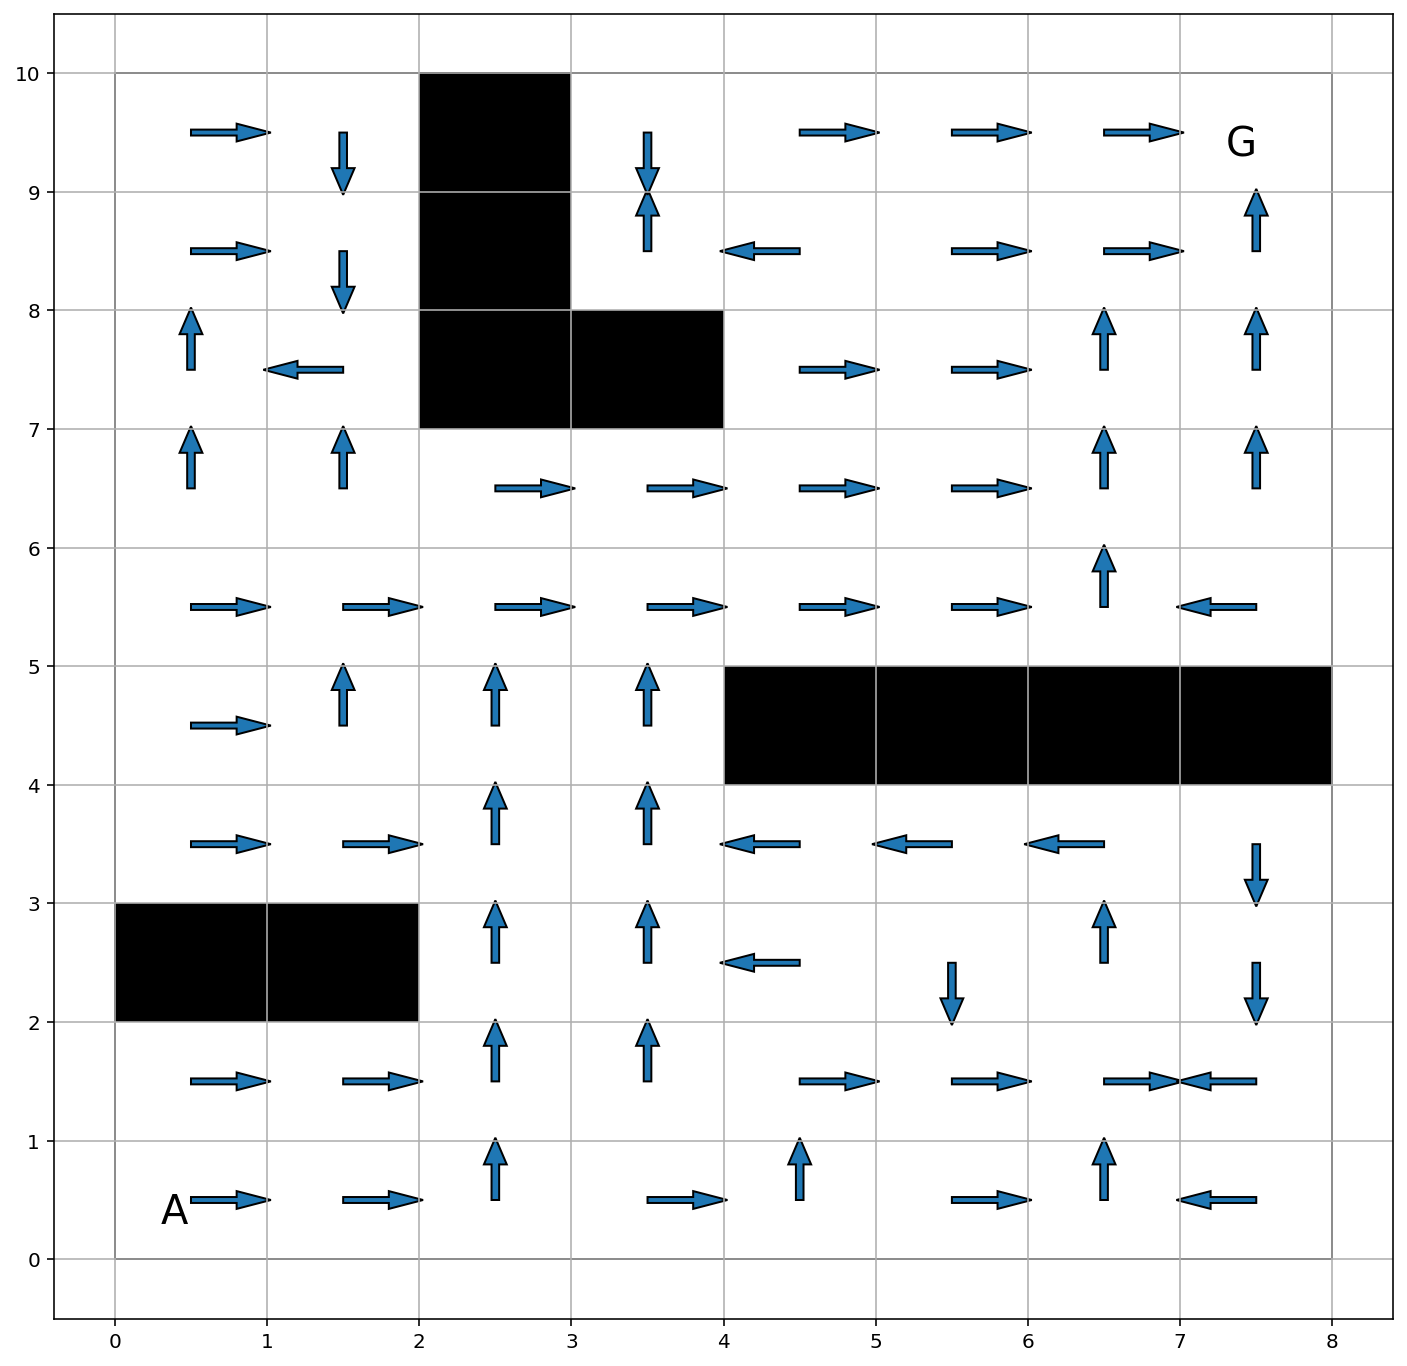

In [36]:
agent.visualize_result()

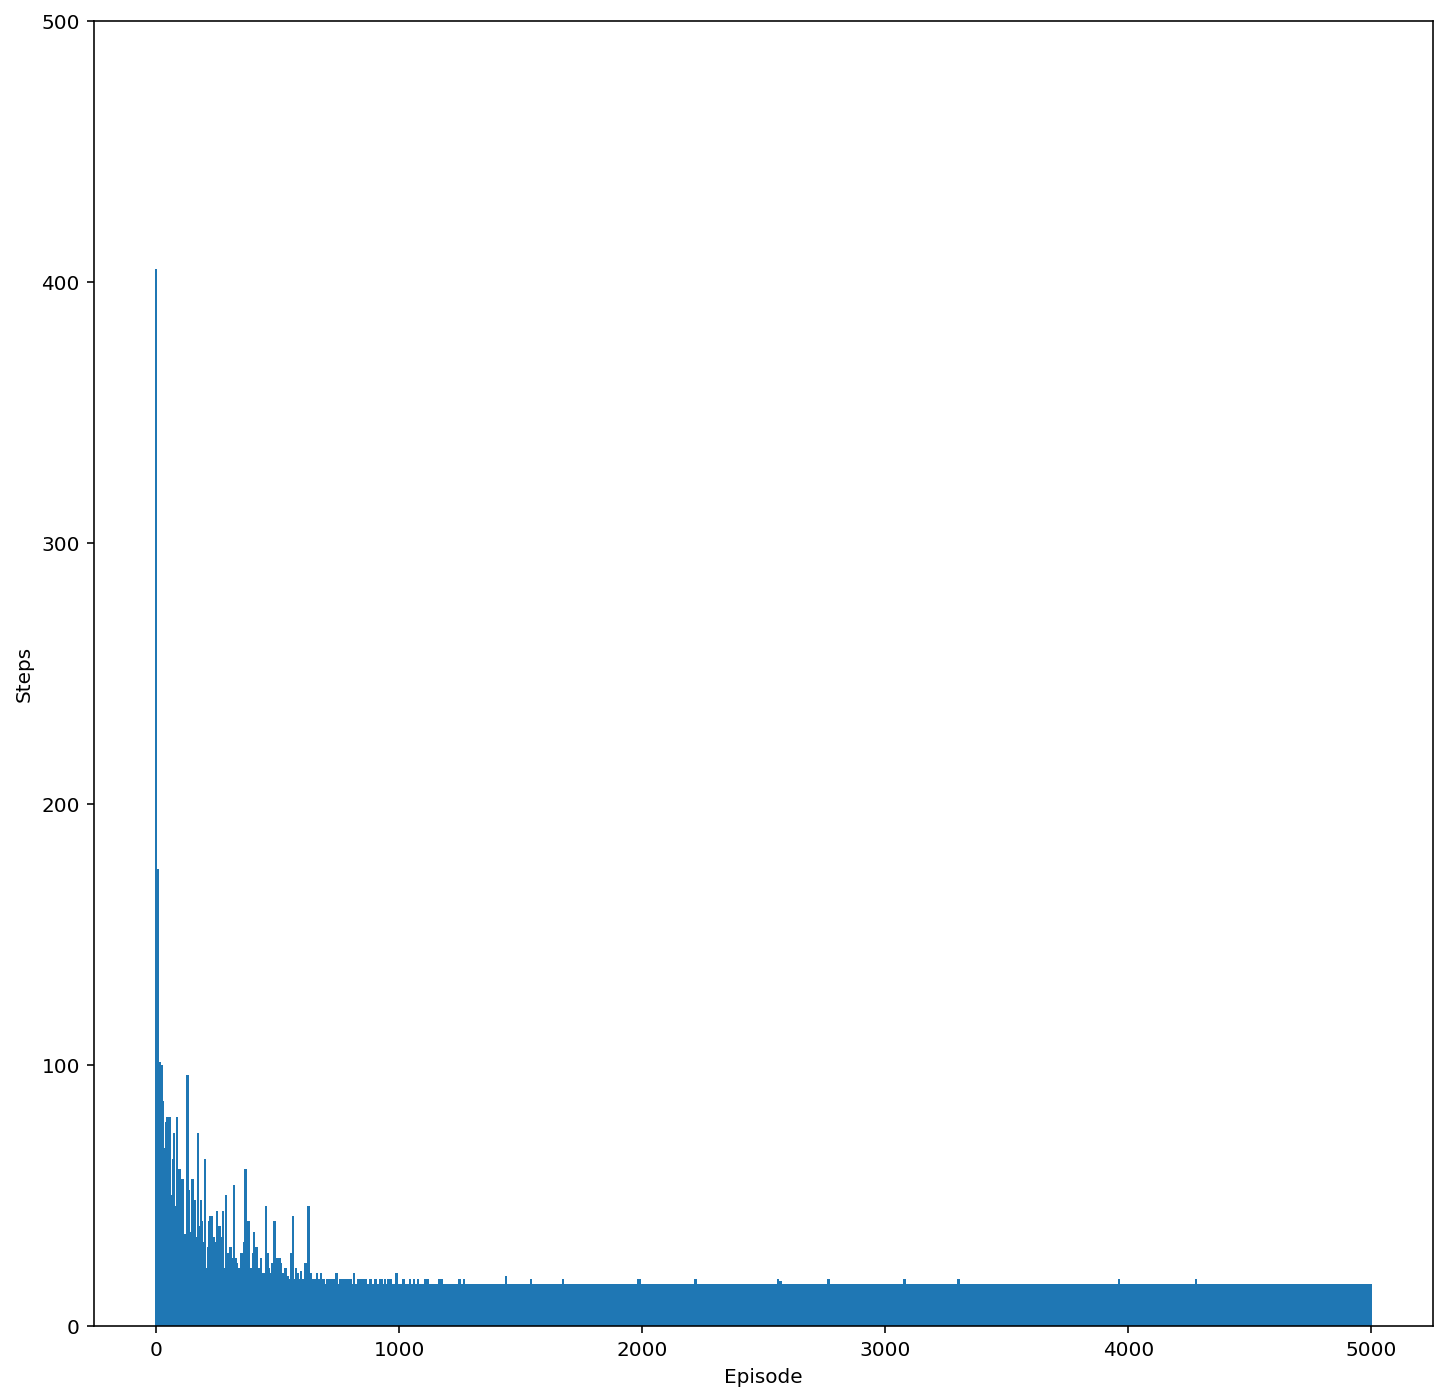

Average episode steps (last 50 episodes):  16.0


In [37]:
plt.bar([i for i in range(len(agent.steps_per_episode))], agent.steps_per_episode, width=10)
plt.ylim([0, 500])
plt.ylabel('Steps')
plt.xlabel('Episode')
plt.show()
print("Average episode steps (last 50 episodes): ", np.average(agent.steps_per_episode[-50:]))
